In [3]:
# File upload to google colab
from google.colab import files
uploaded = files.upload()

Saving mhealth_full.csv to mhealth_full.csv


In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

In [5]:
data = pd.read_csv('mhealth_full.csv')

In [6]:
# Resample activity 0 (null class) to 30720 observations per EDA phase
data_activity_0 = data[data['activity'] == 0]
data_activity_else = data[data['activity'] != 0]

data_activity_0 = data_activity_0.sample(n=30720, random_state=1)
data = pd.concat([data_activity_0, data_activity_else])

In [7]:
# Split data between predictors and output variable
X = data.drop(['activity', 'subject'], axis=1)
y = data['activity']

In [35]:
X.columns

Index(['acc_ch_x', 'acc_ch_y', 'acc_ch_z', 'acc_la_x', 'acc_la_y', 'acc_la_z',
       'gyr_la_x', 'gyr_la_y', 'gyr_la_z', 'mag_la_x', 'mag_la_y', 'mag_la_z',
       'acc_rw_x', 'acc_rw_y', 'acc_rw_z', 'gyr_rw_x', 'gyr_rw_y', 'gyr_rw_z',
       'mag_rw_x', 'mag_rw_y', 'mag_rw_z'],
      dtype='object')

In [37]:
y

978959      0
332102      0
153015      0
776193      0
641719      0
           ..
1213641    12
1213642    12
1213643    12
1213644    12
1213645    12
Name: activity, Length: 373915, dtype: int64

In [8]:
# Scale full set of predictors
X_scaled = StandardScaler().fit_transform(X)

In [9]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)

In [10]:
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Results summarizer function (scores, confusion matrix) for classification results
def results_summarizer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    activity_map = {
        0: 'Null',
        1: 'Standing still',  
        2: 'Sitting and relaxing', 
        3: 'Lying down',  
        4: 'Walking',  
        5: 'Climbing stairs',  
        6: 'Waist bends forward',
        7: 'Frontal elevation of arms', 
        8: 'Knees bending (crouching)', 
        9: 'Cycling', 
        10: 'Jogging', 
        11: 'Running', 
        12: 'Jump front & back' 
    }
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
                xticklabels=activity_map.values(),
                yticklabels=activity_map.values()
               ) 
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Activity')
    plt.ylabel('Actual Activity')
    plt.show()
    
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F_1 Score: ' + '{:.4%}'.format(f1))

In [12]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [13]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train_scaled, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test_scaled, y_test_array]

In [14]:
# Apply sequence transformation using time step of 25 for both train and test data
X_train_seq, y_train_seq = split_sequences(train_set, 25)
print(X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 25)
print(X_test_seq.shape, y_test_seq.shape)

(280412, 25, 21) (280412,)
(93455, 25, 21) (93455,)


In [15]:
# Convert output variables to categorical for CNN
y_train_seq = to_categorical(y_train_seq)
print(y_train_seq.shape)
print(y_train_seq)

y_test_seq = to_categorical(y_test_seq)
print(y_test_seq.shape)
print(y_test_seq)

(280412, 13)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(93455, 13)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq.shape[1], X_train_seq.shape[2], y_train_seq.shape[1]
print(n_timesteps, n_features, n_outputs)

25 21 13


In [15]:
# Build CNN model using keras. For model building suggestions, referenced: 
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model = Sequential()
# 2 1D CNN layers for learning features from the time series samples
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
# Dropout layer for easing learning process
model.add(Dropout(0.5))
# Pooling layer - reduces learned feature sizes to most essential elements
model.add(MaxPooling1D(pool_size=2))
# Flatten learned features to vector
model.add(Flatten())
# Fully connected dense layer - interpret features
model.add(Dense(128, activation='relu'))
# Output layer using softmax
model.add(Dense(n_outputs, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [16]:
# Fit model on training data with 10 epochs
model.fit(X_train_seq, y_train_seq, epochs=10)

Epoch 1/10
8763/8763 [==============================] - 70s 3ms/step - loss: 1.3792 - accuracy: 0.5145
Epoch 2/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.5568 - accuracy: 0.8092
Epoch 3/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.4669 - accuracy: 0.8420
Epoch 4/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.4179 - accuracy: 0.8610
Epoch 5/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.3944 - accuracy: 0.8694
Epoch 6/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.3705 - accuracy: 0.8788
Epoch 7/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.3544 - accuracy: 0.8860
Epoch 8/10
8763/8763 [==============================] - 27s 3ms/step - loss: 0.3397 - accuracy: 0.8899
Epoch 9/10
8763/8763 [==============================] - 28s 3ms/step - loss: 0.3264 - accuracy: 0.8952
Epoch 10/10
8763/8763 [==============================] - 27s 3ms/step - l

In [17]:
# Evaluate model against test data
_, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(accuracy)

2921/2921 [==============================] - 7s 2ms/step - loss: 0.2845 - accuracy: 0.9099
0.9099459648132324


In [18]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = y_pred.reshape(-1,1)
y_pred.shape

(93455, 1)

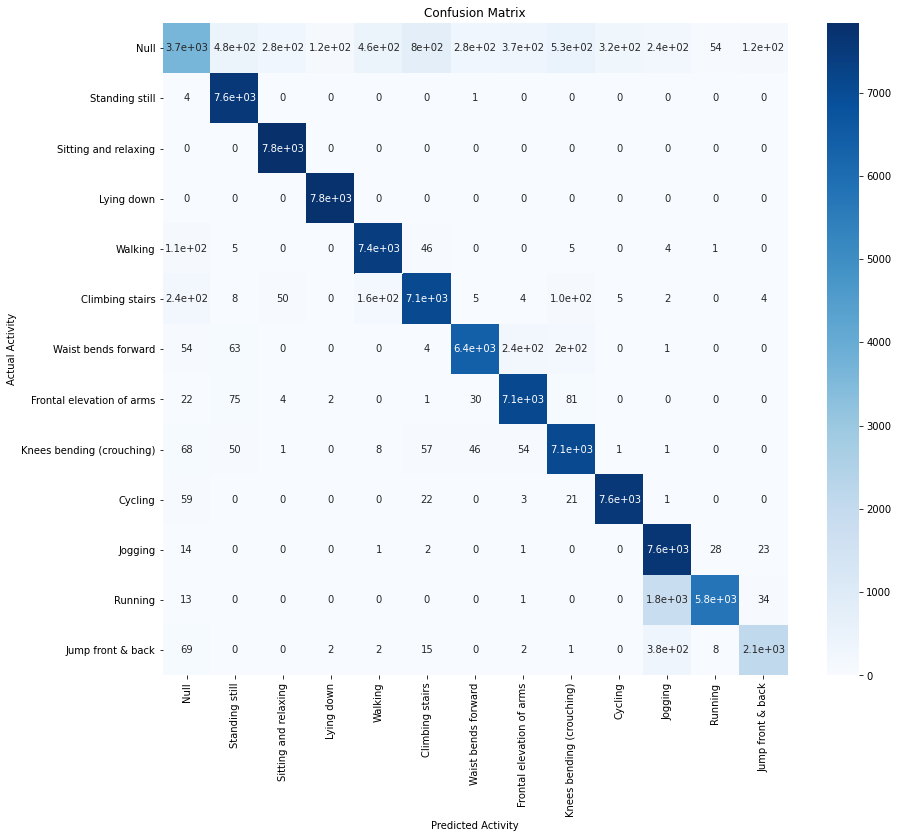

Accuracy Score: 90.9946%
Precision Score: 91.3622%
Recall Score: 90.5699%
F_1 Score: 90.2493%


In [19]:
# Show results
# Note: Needed slice test data to 25 and onwards to match predictions due to time step in model
results_summarizer(y_test[24:], y_pred)

In [17]:
# Transform full data set for use in cross-validation
# Merge X/y data to apply sequence transformation function
y_array = np.array(y)
full_set = np.c_[X_scaled, y_array]
# Apply sequence transformation using time step of 25 for both train and test data
X_seq, y_seq = split_sequences(full_set, 25)
print(X_train_seq.shape, y_train_seq.shape)

(280412, 25, 21) (280412, 13)


In [21]:
# Perform cross validation
scores = []

# Create k fold cross validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_seq, y_seq):
  # Convert output variables to categorical for model
  y_train_seq_cv = to_categorical(y_seq[train])
  y_test_seq_cv = to_categorical(y_seq[test])

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
  model.fit(X_seq[train], y_train_seq_cv, epochs=10)
  _, accuracy = model.evaluate(X_seq[test], y_test_seq_cv)
  scores.append(accuracy)

Epoch 1/10
9348/9348 [==============================] - 30s 3ms/step - loss: 0.1454 - accuracy: 0.9571
Epoch 2/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0204 - accuracy: 0.9949
Epoch 3/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0157 - accuracy: 0.9963
Epoch 4/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0157 - accuracy: 0.9962
Epoch 5/10
9348/9348 [==============================] - 30s 3ms/step - loss: 0.0138 - accuracy: 0.9970
Epoch 6/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0130 - accuracy: 0.9974
Epoch 7/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0154 - accuracy: 0.9974
Epoch 8/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0116 - accuracy: 0.9978
Epoch 9/10
9348/9348 [==============================] - 29s 3ms/step - loss: 0.0127 - accuracy: 0.9977
Epoch 10/10
2337/2337 [==============================] - 6s 2ms/step - lo

In [28]:
print(scores)
print(sum(scores) / len(scores))

[0.9991040229797363, 0.9989168047904968, 0.9989970326423645, 0.9988900423049927, 0.9986359477043152]
0.9989087700843811


NOTE: Test/ train splitting the data AFTER it has been sequenced appears to make a significant impact on classification accuracy. This may be due to the default shuffling effect of sklearn's train_test_split. Attempting model with new test/train split

In [31]:
# Create train and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_seq, y_seq, test_size=0.25, random_state=1)
y_train_new = to_categorical(y_train_new)

In [20]:
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding='same'))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
  model.fit(X_train_new, y_train_new, epochs=10)

Epoch 1/10
8764/8764 [==============================] - 97s 9ms/step - loss: 0.1534 - accuracy: 0.9532
Epoch 2/10
8764/8764 [==============================] - 81s 9ms/step - loss: 0.0213 - accuracy: 0.9948
Epoch 3/10
8764/8764 [==============================] - 79s 9ms/step - loss: 0.0172 - accuracy: 0.9960
Epoch 4/10
8764/8764 [==============================] - 78s 9ms/step - loss: 0.0130 - accuracy: 0.9969
Epoch 5/10
8764/8764 [==============================] - 77s 9ms/step - loss: 0.0136 - accuracy: 0.9971
Epoch 6/10
8764/8764 [==============================] - 77s 9ms/step - loss: 0.0122 - accuracy: 0.9975
Epoch 7/10
8764/8764 [==============================] - 78s 9ms/step - loss: 0.0109 - accuracy: 0.9979
Epoch 8/10
8764/8764 [==============================] - 83s 9ms/step - loss: 0.0123 - accuracy: 0.9977
Epoch 9/10
8764/8764 [==============================] - 79s 9ms/step - loss: 0.0123 - accuracy: 0.9978
Epoch 10/10
8764/8764 [==============================] - 79s 9ms/step - l

In [21]:
# Get summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 64)            4096      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 25, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1

In [26]:
# Make predictions and summarize results
y_pred = model.predict(X_test_new)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = y_pred.reshape(-1,1)

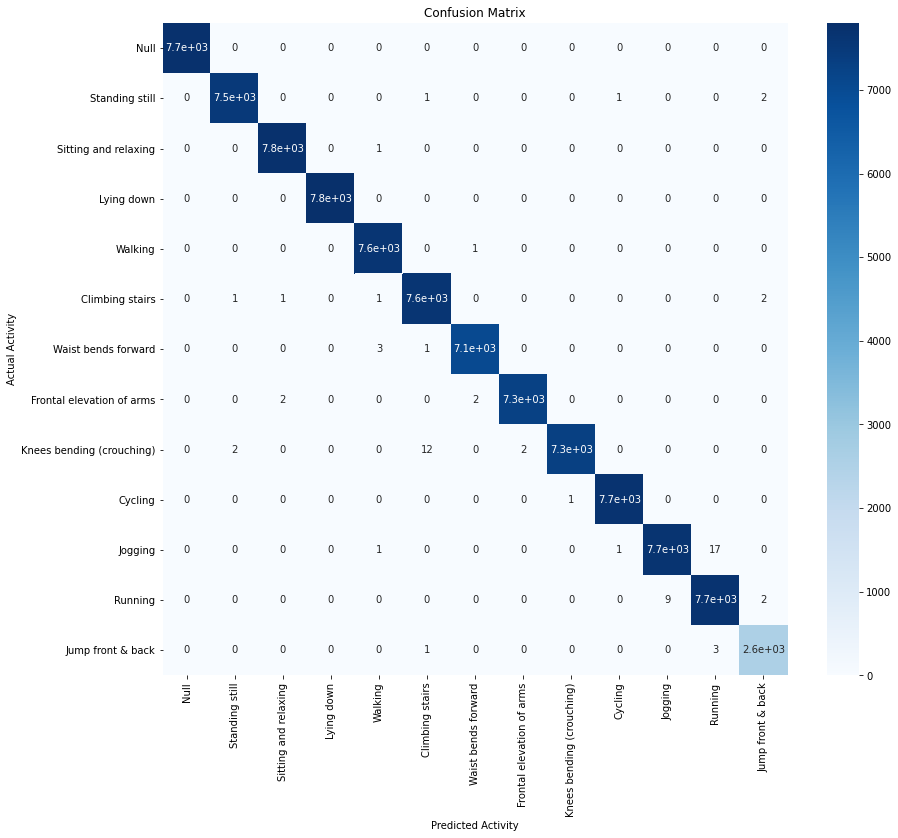

Accuracy Score: 99.9251%
Precision Score: 99.9175%
Recall Score: 99.9206%
F_1 Score: 99.9190%


In [34]:
results_summarizer(y_test_new, y_pred)

Clearly, shuffling data after creating samples (rather than before) results in better outcome. Likely because shuffling before eliminates the actual sequence of the data!